In [1]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy.polynomial.polynomial import Polynomial
from numpy.testing import *

In [3]:
dim = 2
N = [12, 15]#[3,2] # same size as dim
assert_equal(dim,len(N))
Q = [linspace(0,1,n) for n in N]

In [4]:
print(Q[0])

[ 0.          0.09090909  0.18181818  0.27272727  0.36363636  0.45454545
  0.54545455  0.63636364  0.72727273  0.81818182  0.90909091  1.        ]


In [5]:
LL = []
for d in range(dim):
    n = N[d]
    q = Q[d]
    LL += [[Polynomial.fromroots([xj for xj in q if xj != q[i]]) for i in range(n)]]

In [6]:
for d in range(dim):
    n = N[d]
    q = Q[d]
    L = LL[d]
    LL[d] = [L[i]/L[i](q[i]) for i in range(n)]

It is good idea to prepare lists for first and second derivatives of the basis functions. Depending on the problem formulation we will use the appropriate ones.

In [7]:
LL_prime = []
for d in range(dim):
    n = N[d]
    q = Q[d]
    L = LL[d]
    LL_prime += [[L[i].deriv() for i in range(n)]]

In [8]:
LL_prime_prime = []
for d in range(dim):
    n = N[d]
    q = Q[d]
    L_prime = LL_prime[d]
    LL_prime_prime += [[L_prime[i].deriv() for i in range(n)]]

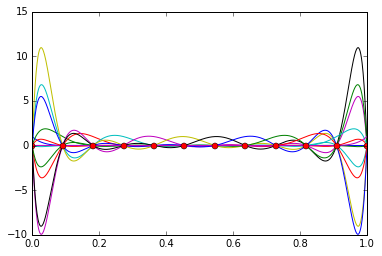

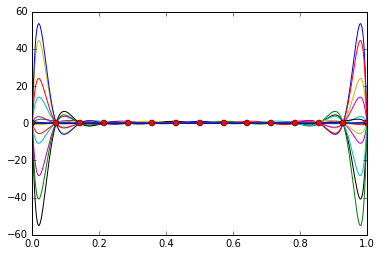

In [9]:
x = linspace(0,1,1025)
for d in range(dim):
    L = LL[d]
    q = Q[d]
    n = N[d]
    figure()
    for f in L:
        plot(x, f(x))
    plot(q, 0*q, 'ro')
    show()

# Two dimensional problems

Assemble one dimensional matrices

$$
B_{bj} := l_j(x_b)
$$
$$
C_{ai} := m_i(y_a)
$$

Monodimensional:

$$
(B u_x)_b  = u_x(x_b), \qquad (C u_y)_a  = u_y(y_a)
$$


In [10]:
x = linspace(0,1,101)
y = linspace(0,1,201)

In [11]:
B=zeros((len(x), N[0]))
C=zeros((len(y), N[1]))

for j in range(N[0]):
    B[:,j] = LL[0][j](x)
    
for i in range(N[1]):
    C[:,i] = LL[1][i](y)

In [12]:
print(C.shape, B.shape)

(201, 15) (101, 12)


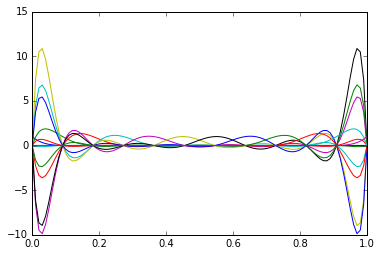

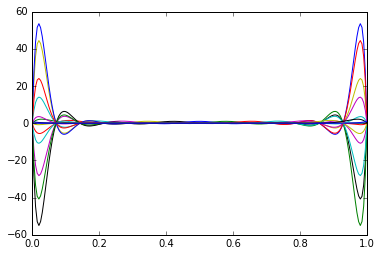

In [13]:
plot(x, B)
show()
plot(y,C)

In [14]:
g = lambda x,y: sin(2*pi*x)*cos(2*pi*y)

If you want to evaluate this function on **x** and **y**, for all combinations of the various x and y, then you have to make sure you **broadcast** them to have the same size. The following does exactly this:

In [15]:
X, Y = meshgrid(x,y) 
G = g(X,Y)

## Plotting 3d plots

A quick search on google gives us the following option:

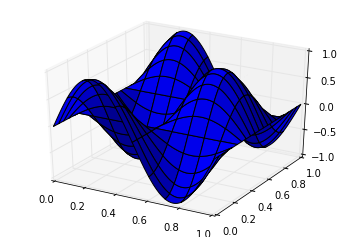

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,g(X,Y))

Use the `einsum` command for a smarter way to plot tensor product functions, remember that tensor product functions are of the form `g1(x)*g2(y)`. 



We aim at solving this problem:
$$
L_{abij} u^{ij} = G_{ab}
$$
where:
$$
u^{ij} = u_x^j\, u_y^i
$$
$$
G_{ab} = g(x_b,y_a)
$$
Remember:
$$
B_{bj} := l_j(x_b)
$$
$$
C_{ai} := m_i(y_a)
$$

In [17]:
L = einsum('ai,bj -> abij', C, B)
L = L.reshape(len(x) * len(y), N[0] * N[1])

``
X,Y = meshgrid(x,y)
``

$$
\mathtt{X} = \left(
\begin{array}{cccc}
x_0 & x_1 & \ldots & x_b \\
x_0 & x_1 & \ldots & x_b \\
\vdots & \vdots & \ddots & \vdots \\
x_0 & x_1 & \ldots & x_b \\
\end{array}
\right), \quad
\mathtt{Y} = \left(
\begin{array}{cccc}
y_0 & y_0 & \ldots & y_0 \\
y_1 & y_1 & \ldots & y_1 \\
\vdots & \vdots & \ddots & \vdots \\
y_n & y_n & \ldots & y_n \\
\end{array}
\right)
$$

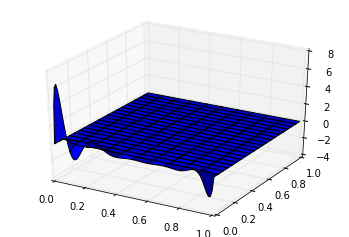

In [18]:
u = zeros((N[0], N[1])).flatten()
u[3] = 1

U = reshape(L.dot(u), (len(y), len(x)))

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,U)

In [19]:
def eval_space(LL,U):
    def eval_sp(LL,U,x,y):
        (ny,nx) = U.shape
        val = 0
        for i in arange(nx):
            for j in arange(ny):
                val += U[j,i]*LL[0][i](x)*LL[1][j](y)
        return val        
    return lambda x,y : eval_sp(LL,U,x,y)

In [20]:
def step_function():
    def sf(x,y):    
        index = where(((x>.3) & (x<.7) & (y>.3) & (y<.7)))
        step = zeros(x.shape)
        step[index] = 1
        return step
    return lambda x,y : sf(x,y)

In [21]:
#g = lambda x,y : sin(pi*x)*cos(pi*y)
g = step_function()

#Sx, Sy = meshgrid(S[0],S[1])

G = g(X,Y).flatten()
print(G.shape)

u = solve(L.T.dot(L), L.T.dot(G))

print(u.shape)

U = u.reshape((N[1],N[0]))

uh = eval_space(LL,U)

(20301,)
(180,)


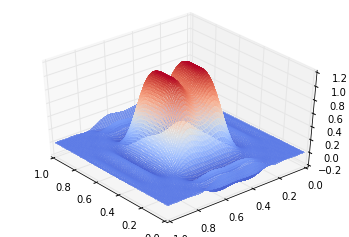

In [23]:
from mpl_toolkits.mplot3d import Axes3D

#X,Y = meshgrid(linspace(0,1,100),linspace(0,1,100))
fig = plt.figure()
ax = fig.gca(projection='3d')

#surf0 = ax.plot_wireframe(X, Y, g(X,Y))
surf1 = ax.plot_surface(X, Y, uh(X,Y), rstride=1, cstride=1, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False, alpha=.5)
ax.view_init(elev=40., azim=140)